## This notebook is for running the MCMC algorithm with different conditions and checking convergence

think of this as a model for what you would run in your python environment to get results

In [1]:
import numpy as np
import pandas as pd

# import main data
data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")

#these are the core functions: 
#chain gives us results
#plot_chain_behaviour shows the results
#likelihood_test does a brute force sweep of the omegas to check the likelihood
from core_mcmc_functions import chain
from core_mcmc_functions import plot_chain_behaviour

In [2]:
#this is not necesarry to import unless you want do systematic error

# import systematic error
data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

#create a likelihood function that uses the systematic error
from prior_likelihood import likelihood

def sys_error_likelihood(params, data):
    return likelihood(params, data, sys_error=sys_error_data)

## How to run the chain function

In [8]:
# here is an example chain, it will run for 4,000 steps at maximum and terminate if the mean of the parameters
# over the previous 1,500 steps is within .5% of the mean of the 1,500 steps before that.

# 'convergence' is very tunable here. A 'convergence failure' doesn't mean the algorithm failed so much as
# you set number of trials too low or an unreasonable convergence threshhold/window.

#we dont use an adaptive variance, so convergence can be slow when you start far from the minima, this is a "fast start state"
fss = [.33, .6, 74, -19.23]
# though, we still get there eventually if we start far away from the minima, this is a "slow start state"
sss = [.96,.2,20,-19.23]

chn, rej = chain(data_lcparam, 4000, 1500, .005, start_state=sss, variances=None, prior_mode='uniform')

#systematic error chain would look like this
# I dont suggest trying a  really slow start state (all parameters very far from expected answers) on this one,
# because it is already quite a bit slower to use the systematic error
# due to the increased complexity of the matrix algebra when finding the likelihood. 
# However, it will converge if you run it long enough.

#chn, rej = chain(data_lcparam, 5000, 1000, .01, start_state=fss, variances='systematic', prior_mode='M_gaussian', likelihood_func=sys_error_likelihood )



total trials:4000. accepted 43.4% of trials
convergence failed. converged parameters: [False  True  True  True]


## Once you have a chain, you can plot the results using this function:
    it has lots of options, detailed in the docstring

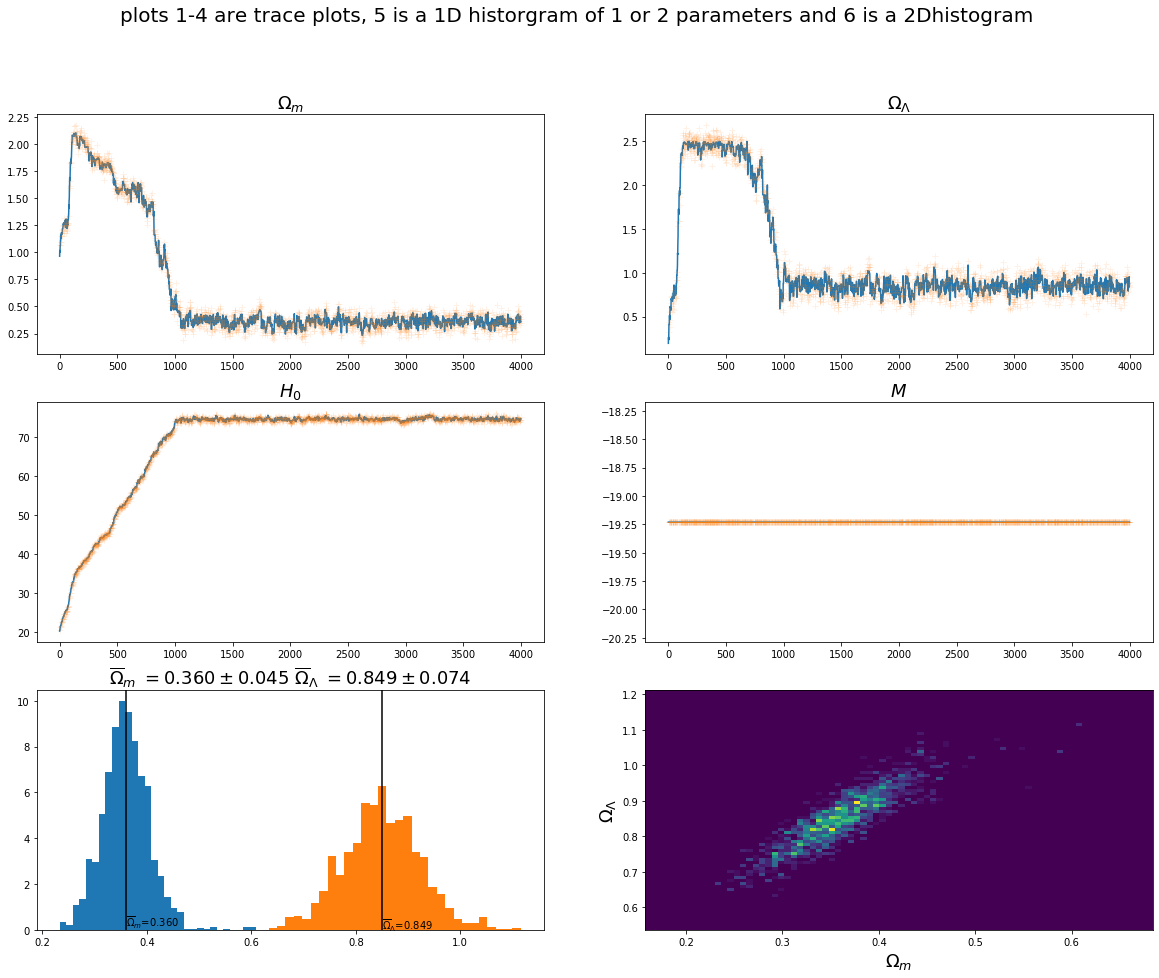

In [9]:
plot_chain_behaviour(chn, rej)

## Tests

In [1]:
from core_mcmc_functions import chain_test
from core_mcmc_functions import likelihood_test 
from core_mcmc_functions import metropolis_test

In [2]:
# the first uses an assert to make sure that the chain converges to the right value in a simpler problem (1D parameter space)
chain_test()

total trials:801. accepted 11.1% of trials
no problems detected


In [3]:
# this tests the metropolis part itself, with fake data hardcoded into the function, see docstring for details
metropolis_test()

'its an old code, but it checks out'

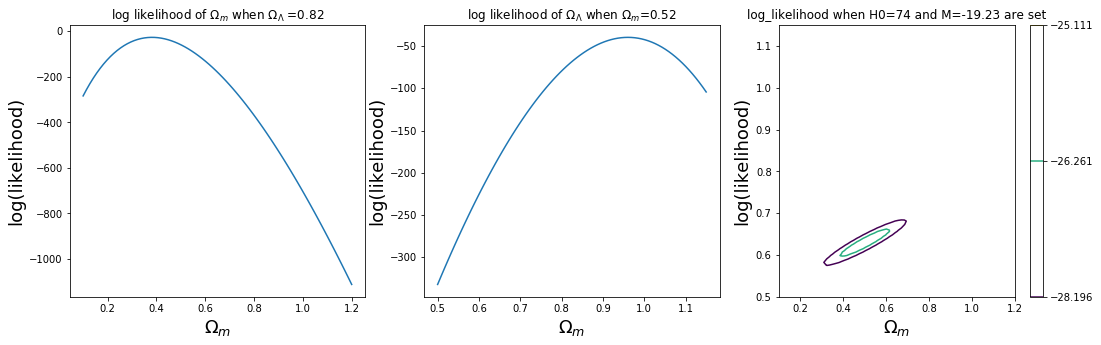

In [2]:
# the second test shows plots of the likelihood by using a brute force parameter sweep in 2 dimensions. no assert
# in this test, I dont think this kind of test lends itself to an assert statement, though it could be shoehorned
# its only required argument is how fine of a grid we want to test over. bigger = more test points as N^2

likelihood_test(80)

## BONUS: estimating your own covariance matrix for the generating function
these commands estimate the covariance matrix from a sample chain 'chn'. You can take the result and put it into your chain algorithm by setting the keyword variances=cov if you are trying to increase convergence rates.

In [25]:
#scaling should probably be no more than 1, or you will get a very low acceptance rates
scaling=1
cutoff = int(len(chn[:,0])/5)
cchn = chn[cutoff:,:] 
cov=np.cov(cchn, y=None, rowvar=False)
cov=scaling* cov/np.max(np.abs(cov))